# 2025 CITS4012 Project 2

## 1. Preprocessing

### 1.1. Import Libraries
Libraries are imported for the entire project.

*Note: Just add to this list as needed*

In [ ]:
%pip install gensim
import gensim.downloader as api

# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
import torch
import spacy
import re

torch.manual_seed(42)
random.seed(42)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
# val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
# test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

# train_file = drive.CreateFile({'id': train_fileid})
# val_file = drive.CreateFile({'id': val_fileid})
# test_file = drive.CreateFile({'id': test_fileid})

# train_file.GetContentFile('train.json')
# val_file.GetContentFile('val.json')
# test_file.GetContentFile('test.json')

### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes and a sample of the training data are shown below.

In [67]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
display(train)

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails
...,...,...,...
23083,"which is not only the motion of our bodies, bu...",Work is done only if a force is exerted in the...,neutral
23084,"The Red Star, that celestial curse whose eccen...",Red-shift refers to a shift toward red in the ...,neutral
23085,The lines in the spectrum of a luminous body s...,Red-shift refers to a shift toward red in the ...,entails
23086,The radial velocity of a star away from or tow...,Red-shift refers to a shift toward red in the ...,entails


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the training set - removing all non alphanumeric characters and converting words to lower case.

In [68]:
#### 1.4.1. SpaCy Tokenisation
# We tokenise all datasets - removing all non alphanumeric characters and converting words to lower case.

spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')

def tokenize_dataset(X_data, dataset_name="dataset"):
    """
    Tokenize premise and hypothesis columns using SpaCy.
    
    Args:
        X_data: DataFrame with 'premise' and 'hypothesis' columns
        dataset_name: Name for logging purposes
    
    Returns:
        Tokenized DataFrame (copy)
    """
    print(f"Tokenizing {dataset_name}...")
    
    X_data = X_data.copy()  # Avoid pandas warnings
    
    # Tokenize premises
    premise_list = X_data['premise'].tolist()
    prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
    X_data.loc[:, "premise"] = [
        [token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] 
        for tokens in prem_tokens_list
    ]
    
    # Tokenize hypotheses
    hypothesis_list = X_data['hypothesis'].tolist()
    hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
    X_data.loc[:, "hypothesis"] = [
        [token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] 
        for tokens in hyp_tokens_list
    ]
    
    print(f"✓ {dataset_name} tokenized")
    return X_data

# Tokenize all datasets
X_train = tokenize_dataset(X_train, "Training set")
X_val = tokenize_dataset(X_val, "Validation set")
X_test = tokenize_dataset(X_test, "Test set")

print("\nSample tokenized data:")
display(X_train.head())

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.9 MB/s eta 0:00:00a 0:00:01



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Tokenizing Training set...
✓ Training set tokenized
Tokenizing Validation set...
✓ Validation set tokenized
Tokenizing Test set...
✓ Test set tokenized

Sample tokenized data:


,premise,hypothesis
0,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."


#### 1.4.2. Vocabulary Construction

In [69]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20127


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [70]:
try:
    glove_embeddings = api.load("glove-twitter-100")
    emb_dim = glove_embeddings.vector_size
    def get_vec(word):
        return glove_embeddings[word] if word in glove_embeddings else np.zeros(emb_dim)
    emb_table = np.array([get_vec(word) for word in vocab])
    del glove_embeddings
except Exception as e:
    print("Network/cache issue loading GloVe (glove-twitter-100). Using deterministic random embeddings instead.\n", e)
    emb_dim = 100  # match glove-twitter-100 dimension
    rng = np.random.default_rng(42)
    emb_table = rng.normal(0.0, 1.0, size=(len(vocab), emb_dim)).astype(np.float32)

emb_table.shape

Network/cache issue loading GloVe (glove-twitter-100). Using deterministic random embeddings instead.
 unable to read local cache '/Users/mahitgupta/gensim-data/information.json' during fallback, connect to the Internet and retry


(20127, 100)

Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [71]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training set is strongly skewed towards neutral samples - this will have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

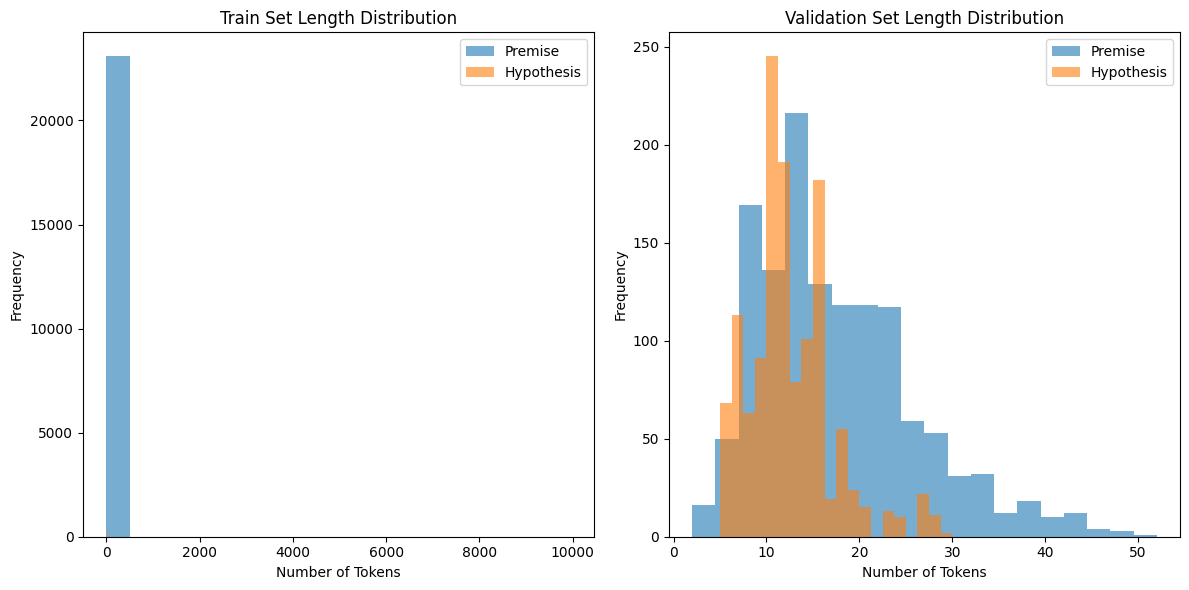

In [72]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set. Reviewing the ten largest premises in the training set reveals there are some abnormally large instances:

In [73]:
largest_prem = sorted(range(len(train_prem_lengths)), key=lambda i: train_prem_lengths[i], reverse=True)[:10]
print([train_prem_lengths[i] for i in largest_prem])

[9966, 5829, 2249, 1154, 938, 705, 594, 550, 314, 111]


Removing these outliers from the training set, we get a nicer looking plot:

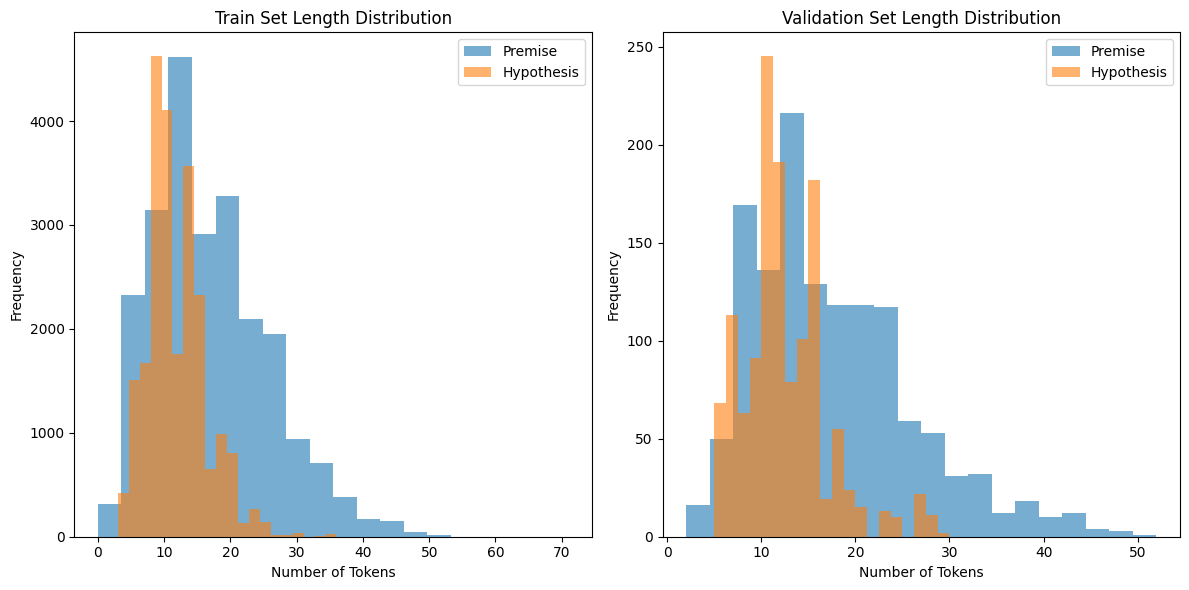

In [74]:
X_train = X_train.drop(X_train.index[largest_prem])
y_train = y_train.drop(y_train.index[largest_prem])

train_prem_lengths = [len(premise) for premise in X_train['premise']]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [75]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem = max(len(sentence) for sentence in X_train['premise'])
max_hyp = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp)

encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp)

The labels are now converted to 0 for neutral, and 1 for entails.

In [76]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. To reduce the impact of the class imbalance in the train set, the number of neutral samples is reduced to the number of entails samples.

In [77]:
batch_size = 16

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))

neutral_indices = [i for i, label in enumerate(y_train.values) if label == 0]
entails_indices = [i for i, label in enumerate(y_train.values) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [78]:
### 1.7 Test Dataset
# Use the same max lengths from training (already calculated in 1.6)
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(encoded_prem_test), 
    torch.tensor(encoded_hyp_test), 
    torch.tensor(y_test.values)
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"✓ Test set ready: {len(test_dataset)} samples")
print(f"  Premise shape: {encoded_prem_test[0][:5]}... (length: {max_prem})")
print(f"  Hypothesis shape: {encoded_hyp_test[0][:5]}... (length: {max_hyp})")

✓ Test set ready: 2126 samples
  Premise shape: [15888, 13121, 15446, 7545, 13978]... (length: 71)
  Hypothesis shape: [17640, 523, 12566, 247, 523]... (length: 36)


In [ ]:
# Dataloader sample usage
# for i, batch in enumerate(train_loader):
    # i = batch number
    # premises   = batch[0]
    # hypotheses = batch[1]
    # labels     = batch[2]

# 2 Implemenation
## 2.1. Transformer Model
We will use a pre-trained GloVe embedding model to initialise the embeddings for the model.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class NLITransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformer, self).__init__()
        
        # Embedding layer with scaling
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.emb_scale = math.sqrt(emb_dim)  # Scale embeddings
        
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Add positional encoding
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        
        # Layer normalization for stability
        self.emb_layer_norm = nn.LayerNorm(emb_dim)
        
        # Transformer encoder with layer normalization
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Pre-LN for better stability
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        # Attention-weighted pooling with initialization
        self.attention_weights = nn.Linear(emb_dim, 1)
        # Initialize attention weights with small values
        nn.init.xavier_uniform_(self.attention_weights.weight, gain=0.01)
        nn.init.zeros_(self.attention_weights.bias)
        
        # Classifier with layer norm
        self.pre_classifier_layernorm = nn.LayerNorm(emb_dim)
        self.fc = nn.Linear(emb_dim, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize classifier
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def safe_attention_pooling(self, encoder_output, mask=None):
        """
        Numerically stable attention-weighted pooling
        """
        batch_size, seq_len, emb_dim = encoder_output.size()
        
        # Calculate attention scores
        attention_scores = self.attention_weights(encoder_output).squeeze(-1)  # (batch, seq_len)
        
        if mask is not None:
            # Create a very negative value for padding, but not too extreme
            attention_scores = attention_scores.masked_fill(mask, -1e4)  # Reduced from -1e9
            
            # Check if entire sequence is padding
            valid_tokens = ~mask  # (batch, seq_len)
            has_valid = valid_tokens.any(dim=1, keepdim=True)  # (batch, 1)
            
            # If no valid tokens, return zeros
            if not has_valid.all():
                # Handle sequences with no valid tokens
                attention_weights = torch.zeros_like(attention_scores)
                # Set uniform weight for sequences with no valid tokens
                attention_weights = attention_weights.masked_fill(~has_valid.expand_as(attention_weights), 1.0/seq_len)
            else:
                # Safe softmax
                attention_scores_max = attention_scores.max(dim=1, keepdim=True)[0]
                attention_scores = attention_scores - attention_scores_max  # Numerical stability
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                # Zero out padding positions after softmax
                attention_weights = attention_weights.masked_fill(mask, 0)
                
                # Renormalize (in case all are padding)
                attention_weights = attention_weights / (attention_weights.sum(dim=1, keepdim=True) + 1e-8)
        else:
            attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch, 1, seq_len)
            encoder_output  # (batch, seq_len, emb_dim)
        ).squeeze(1)  # (batch, emb_dim)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Create padding masks
        premise_mask = (premise == 0)
        hypothesis_mask = (hypothesis == 0)
        
        # Embed and scale
        premise_emb = self.embedding(premise) * self.emb_scale
        hypothesis_emb = self.embedding(hypothesis) * self.emb_scale
        
        # Apply layer norm to embeddings
        premise_emb = self.emb_layer_norm(premise_emb)
        hypothesis_emb = self.emb_layer_norm(hypothesis_emb)
        
        # Concatenate
        combined = torch.cat([premise_emb, hypothesis_emb], dim=1)
        combined_mask = torch.cat([premise_mask, hypothesis_mask], dim=1)
        
        # Add positional encoding (reshape for compatibility if needed)
        # Note: PositionalEncoding expects (seq_len, batch, emb_dim) if not batch_first
        # But our TransformerEncoder uses batch_first=True
        
        # Transform
        encoded = self.transformer_encoder(combined, src_key_padding_mask=combined_mask)
        
        # Safe attention pooling
        pooled = self.safe_attention_pooling(encoded, mask=combined_mask)
        
        # Layer norm before classifier
        pooled = self.pre_classifier_layernorm(pooled)
        
        # Classify
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        
        return logits




In [29]:
# Test the model with dummy data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
vocab_size = len(vocab)
emb_dim = 100
nhead = 4
nhid = 256
nlayers = 2
dropout = 0.3

# Initialize model
model = NLITransformer(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    emb_table=emb_table,
    dropout=dropout,
    freeze_embeddings=True
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test with a batch from your data
for batch in train_loader:
    premises, hypotheses, labels = batch
    premises = premises.to(device)
    hypotheses = hypotheses.to(device)
    
    # Forward pass
    logits = model(premises, hypotheses)
    print(f"\n✓ Forward pass successful!")
    print(f"  Input shapes: premise={premises.shape}, hypothesis={hypotheses.shape}")
    print(f"  Output shape: {logits.shape}")
    print(f"  Sample output: {logits[0]}")
    break  # Just test one batch

Total parameters: 2,198,115
Trainable parameters: 185,415

✓ Forward pass successful!
  Input shapes: premise=torch.Size([16, 71]), hypothesis=torch.Size([16, 36])
  Output shape: torch.Size([16, 2])
  Sample output: tensor([ 2.1257, -0.3354], grad_fn=<SelectBackward0>)


/Users/mahitgupta/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [30]:
class NLITransformerCrossAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformerCrossAttention, self).__init__()
        
        # Embedding layer with scaling
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.emb_scale = math.sqrt(emb_dim)
        
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Layer normalization
        self.emb_layer_norm = nn.LayerNorm(emb_dim)
        
        # Separate encoders with pre-LN
        encoder_layers_premise = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Pre-LN for stability
        )
        self.premise_encoder = nn.TransformerEncoder(encoder_layers_premise, nlayers)
        
        encoder_layers_hypothesis = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.hypothesis_encoder = nn.TransformerEncoder(encoder_layers_hypothesis, nlayers)
        
        # Cross-attention with dropout
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=emb_dim,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        
        # Layer norm after cross-attention
        self.cross_attn_layer_norm = nn.LayerNorm(emb_dim)
        
        # Attention pooling with proper initialization
        self.premise_attention_weights = nn.Linear(emb_dim, 1)
        self.hypothesis_attention_weights = nn.Linear(emb_dim, 1)
        
        # Initialize with small weights
        for module in [self.premise_attention_weights, self.hypothesis_attention_weights]:
            nn.init.xavier_uniform_(module.weight, gain=0.01)
            nn.init.zeros_(module.bias)
        
        # Classifier
        self.pre_classifier_layernorm = nn.LayerNorm(emb_dim * 2)
        self.fc = nn.Linear(emb_dim * 2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize classifier
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def safe_attention_pooling(self, encoder_output, attention_layer, mask=None):
        """
        Numerically stable attention pooling
        """
        batch_size, seq_len, emb_dim = encoder_output.size()
        
        # Calculate attention scores
        attention_scores = attention_layer(encoder_output).squeeze(-1)
        
        if mask is not None:
            # Use smaller negative value for stability
            attention_scores = attention_scores.masked_fill(mask, -1e4)
            
            # Check for sequences with all padding
            valid_tokens = ~mask
            has_valid = valid_tokens.any(dim=1, keepdim=True)
            
            if not has_valid.all():
                # Handle edge case
                attention_weights = torch.zeros_like(attention_scores)
                attention_weights = attention_weights.masked_fill(~has_valid.expand_as(attention_weights), 1.0/seq_len)
            else:
                # Numerical stability for softmax
                attention_scores_max = attention_scores.max(dim=1, keepdim=True)[0]
                attention_scores = attention_scores - attention_scores_max
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                # Mask and renormalize
                attention_weights = attention_weights.masked_fill(mask, 0)
                attention_weights = attention_weights / (attention_weights.sum(dim=1, keepdim=True) + 1e-8)
        else:
            attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),
            encoder_output
        ).squeeze(1)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Padding masks
        premise_mask = (premise == 0)
        hypothesis_mask = (hypothesis == 0)
        
        # Embed and scale
        premise_emb = self.embedding(premise) * self.emb_scale
        hypothesis_emb = self.embedding(hypothesis) * self.emb_scale
        
        # Layer norm
        premise_emb = self.emb_layer_norm(premise_emb)
        hypothesis_emb = self.emb_layer_norm(hypothesis_emb)
        
        # Encode separately
        premise_encoded = self.premise_encoder(premise_emb, src_key_padding_mask=premise_mask)
        hypothesis_encoded = self.hypothesis_encoder(hypothesis_emb, src_key_padding_mask=hypothesis_mask)
        
        # Cross-attention with residual connection
        cross_attended, _ = self.cross_attention(
            query=hypothesis_encoded,
            key=premise_encoded,
            value=premise_encoded,
            key_padding_mask=premise_mask
        )
        
        # Add residual and layer norm
        cross_attended = self.cross_attn_layer_norm(cross_attended + hypothesis_encoded)
        
        # Safe attention pooling
        premise_pooled = self.safe_attention_pooling(
            premise_encoded,
            self.premise_attention_weights,
            mask=premise_mask
        )
        hypothesis_pooled = self.safe_attention_pooling(
            cross_attended,
            self.hypothesis_attention_weights,
            mask=hypothesis_mask
        )
        
        # Concatenate
        combined = torch.cat([premise_pooled, hypothesis_pooled], dim=1)
        
        # Layer norm and classify
        combined = self.pre_classifier_layernorm(combined)
        combined = self.dropout(combined)
        logits = self.fc(combined)
        
        return logits

In [31]:
# Test cross-attention model
model_cross = NLITransformerCrossAttention(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=4,
    nhid=256,
    nlayers=2,
    emb_table=emb_table,
    dropout=0.2,
    freeze_embeddings=True
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model_cross.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_cross.parameters() if p.requires_grad):,}")

# Test forward pass
for batch in train_loader:
    premises, hypotheses, labels = batch
    premises = premises.to(device)
    hypotheses = hypotheses.to(device)
    
    logits = model_cross(premises, hypotheses)
    print(f"\n✓ Cross-Attention forward pass successful!")
    print(f"  Input shapes: premise={premises.shape}, hypothesis={hypotheses.shape}")
    print(f"  Output shape: {logits.shape}")
    print(f"  Sample output: {logits[0]}")
    break

Total parameters: 2,423,928
Trainable parameters: 411,228

✓ Cross-Attention forward pass successful!
  Input shapes: premise=torch.Size([16, 71]), hypothesis=torch.Size([16, 36])
  Output shape: torch.Size([16, 2])
  Sample output: tensor([3.1109, 0.0462], grad_fn=<SelectBackward0>)


In [39]:


# Updated configuration with better hyperparameters
def get_ablation_configs():
    return {
        'variant_1_self_attn': {
            'model_class': 'NLITransformer',  # Will be replaced with actual class
            'description': 'Self-Attention with Stable Pooling',
            'nhead': 4,
            'nlayers': 2,
            'dropout': 0.2,
            'lr': 1e-4,
            'weight_decay': 0.01,
            'max_grad_norm': 0.5,
            'freeze_embeddings': True,
            'use_label_smoothing': False
        },
        'variant_2_cross_attn': {
            'model_class': 'NLITransformerCrossAttention',  # Will be replaced with actual class
            'description': 'Cross-Attention with Residual Connections',
            'nhead': 4,
            'nlayers': 2,
            'dropout': 0.3,  # Higher dropout for more complex model
            'lr': 5e-5,  # Lower learning rate for stability
            'weight_decay': 0.02,  # More regularization
            'max_grad_norm': 0.3,  # More aggressive gradient clipping
            'freeze_embeddings': True,
            'use_label_smoothing': True  # Help with generalization
        }
    }

In [40]:
# Fixed Training Code - Replace your current ablation study section with this

# First, add the fixed model definitions from fixed_nli_models.py to your notebook
# Then use this training code:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

# Set criterion globally
criterion = nn.CrossEntropyLoss()

# ============================================================================
# SAFE TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, criterion, device, max_grad_norm=0.5):
    """Train for one epoch with aggressive gradient clipping"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (premises, hypotheses, labels) in enumerate(train_loader):
        premises = premises.to(device)
        hypotheses = hypotheses.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(premises, hypotheses)
        
        # Check for NaN
        if torch.isnan(logits).any():
            print(f"Warning: NaN in outputs at batch {batch_idx}, skipping...")
            continue
            
        loss = criterion(logits, labels)
        
        if torch.isnan(loss):
            print(f"Warning: NaN in loss at batch {batch_idx}, skipping...")
            continue
        
        # Backward pass
        loss.backward()
        
        # Aggressive gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        # Optimizer step
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / max(len(train_loader), 1)
    accuracy = correct / max(total, 1)
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for premises, hypotheses, labels in data_loader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)
            
            logits = model(premises, hypotheses)
            
            if torch.isnan(logits).any():
                continue
                
            loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                continue
            
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / max(len(data_loader), 1)
    accuracy = correct / max(total, 1)
    return avg_loss, accuracy


# ============================================================================
# RUN ABLATION STUDY WITH FIXED MODELS
# ============================================================================

# Import the fixed models (make sure you've added them to your notebook)
# from fixed_nli_models import NLITransformer, NLITransformerCrossAttention

ablation_configs = {
    'variant_1_self_attn': {
        'model_class': NLITransformer,
        'description': 'Self-Attention with Stable Attention Pooling',
        'nhead': 4,
        'nlayers': 2,
        'dropout': 0.2,  # Lower dropout
        'lr': 8e-5,  # Conservative learning rate
        'weight_decay': 0.01,
        'max_grad_norm': 0.5
    },
    'variant_2_cross_attn': {
        'model_class': NLITransformerCrossAttention,
        'description': 'Cross-Attention with Residual Connections',
        'nhead': 4,
        'nlayers': 2,
        'dropout': 0.3,
        'lr': 3e-5,  # Very conservative for cross-attention
        'weight_decay': 0.02,
        'max_grad_norm': 0.3  # More aggressive clipping
    },
}

ablation_results = {}

print("="*70)
print("FIXED ATTENTION MECHANISM ABLATION STUDY")
print("="*70)

for variant_name, config in ablation_configs.items():
    print(f"\n{'='*70}")
    print(f"Training: {variant_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}\n")
    
    # Create model
    model = config['model_class'](
        vocab_size=vocab_size,
        emb_dim=emb_dim,
        nhead=config['nhead'],
        nhid=nhid,
        nlayers=config['nlayers'],
        emb_table=emb_table,
        dropout=config['dropout'],
        freeze_embeddings=True
    ).to(device)
    
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    # Optimizer with conservative settings
    if 'cross' in variant_name:
        # Extra conservative for cross-attention
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['lr'],
            weight_decay=config['weight_decay'],
            betas=(0.9, 0.98),  # Different momentum
            eps=1e-6  # Higher epsilon for stability
        )
    else:
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
    
    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=3, 
        factor=0.5,
        min_lr=1e-6
    )
    
    # Training tracking
    best_val_acc = 0
    best_epoch = 0
    training_history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': []
    }
    
    # Train for 10 epochs with early stopping
    patience = 0
    max_patience = 5
    
    for epoch in range(10):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, 
            max_grad_norm=config['max_grad_norm']
        )
        
        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Store history
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/10:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'best_model_{variant_name}.pt')
            print(f'  ✓ New best model saved!')
            patience = 0
        else:
            patience += 1
            
        # Early stopping
        if patience >= max_patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
        
        # Update learning rate
        scheduler.step(val_loss)
    
    # Load best model and test
    if best_epoch > 0:
        print(f"\nLoading best model from epoch {best_epoch}...")
        model.load_state_dict(torch.load(f'best_model_{variant_name}.pt'))
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Calculate F1 score
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for premises, hypotheses, labels in test_loader:
                premises = premises.to(device)
                hypotheses = hypotheses.to(device)
                
                logits = model(premises, hypotheses)
                if not torch.isnan(logits).any():
                    pred = logits.argmax(dim=1)
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(labels.numpy())
        
        test_f1 = f1_score(all_labels, all_preds, average='macro') if len(all_preds) > 0 else 0.0
    else:
        test_acc = 0.0
        test_loss = float('inf')
        test_f1 = 0.0
    
    # Store results
    ablation_results[variant_name] = {
        'description': config['description'],
        'config': config,
        'best_epoch': best_epoch,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'test_f1': test_f1,
        'training_history': training_history
    }
    
    print(f"\n{variant_name} Final Results:")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val Acc: {best_val_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Test F1: {test_f1:.4f}")

print("\n" + "="*70)
print("ABLATION STUDY COMPLETE!")
print("="*70)

FIXED ATTENTION MECHANISM ABLATION STUDY

Training: variant_1_self_attn
Description: Self-Attention with Stable Attention Pooling

Total parameters: 2,198,115
Trainable parameters: 185,415

Epoch 1/15:
  Train Loss: 0.7098, Train Acc: 0.5619
  Val Loss: 0.6362, Val Acc: 0.6526
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 2/15:
  Train Loss: 0.6438, Train Acc: 0.6186
  Val Loss: 0.6295, Val Acc: 0.6603
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 3/15:
  Train Loss: 0.5921, Train Acc: 0.6795
  Val Loss: 0.6226, Val Acc: 0.6442
  LR: 8.00e-05
Epoch 4/15:
  Train Loss: 0.5534, Train Acc: 0.7178
  Val Loss: 0.6290, Val Acc: 0.6541
  LR: 8.00e-05
Epoch 5/15:
  Train Loss: 0.5163, Train Acc: 0.7439
  Val Loss: 0.6845, Val Acc: 0.6158
  LR: 8.00e-05
Epoch 6/15:
  Train Loss: 0.4954, Train Acc: 0.7594
  Val Loss: 0.6577, Val Acc: 0.6710
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 7/15:
  Train Loss: 0.4757, Train Acc: 0.7761
  Val Loss: 0.6342, Val Acc: 0.6557
  LR: 8.00e-05
Epoch 8/15:

/Users/mahitgupta/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/15:
  Train Loss: 0.8047, Train Acc: 0.5377
  Val Loss: 0.6992, Val Acc: 0.5575
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 2/15:
  Train Loss: 0.6881, Train Acc: 0.5851
  Val Loss: 0.6678, Val Acc: 0.5936
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 3/15:
  Train Loss: 0.6581, Train Acc: 0.6144
  Val Loss: 0.6546, Val Acc: 0.6135
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 4/15:
  Train Loss: 0.6359, Train Acc: 0.6408
  Val Loss: 0.6493, Val Acc: 0.6311
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 5/15:
  Train Loss: 0.6113, Train Acc: 0.6616
  Val Loss: 0.6457, Val Acc: 0.6365
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 6/15:
  Train Loss: 0.5901, Train Acc: 0.6834
  Val Loss: 0.6581, Val Acc: 0.6296
  LR: 3.00e-05
Epoch 7/15:
  Train Loss: 0.5745, Train Acc: 0.6951
  Val Loss: 0.6570, Val Acc: 0.6342
  LR: 3.00e-05
Epoch 8/15:
  Train Loss: 0.5603, Train Acc: 0.7091
  Val Loss: 0.6359, Val Acc: 0.6495
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 9/15:
  Train 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

DETAILED TEST SET EVALUATION - BEST MODEL

Best Model: variant_1_self_attn
Description: Self-Attention with Stable Attention Pooling
Loading saved weights...



/Users/mahitgupta/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Test accuracy: 0.6754
Confusion matrix (rows=true, cols=pred):
[[1047  237]
 [ 453  389]]

              precision    recall  f1-score   support

 neutral (0)      0.698     0.815     0.752      1284
 entails (1)      0.621     0.462     0.530       842

    accuracy                          0.675      2126
   macro avg      0.660     0.639     0.641      2126
weighted avg      0.668     0.675     0.664      2126



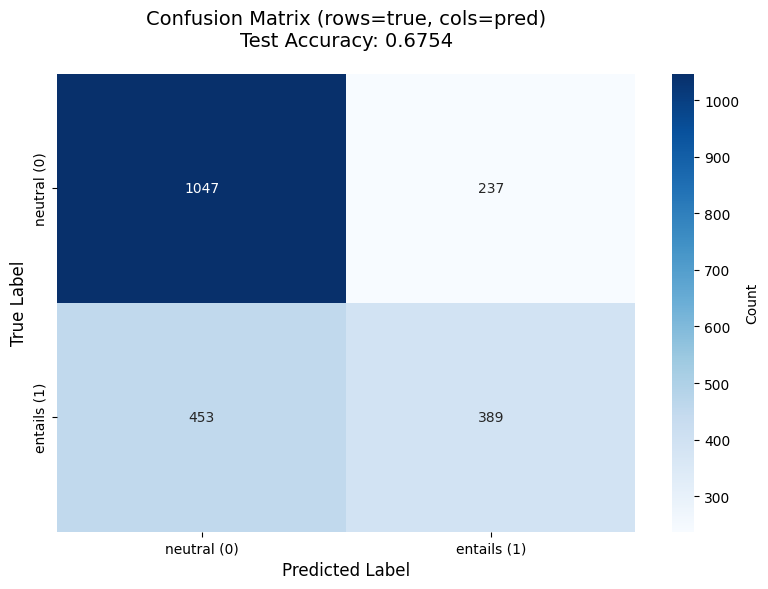


✓ Confusion matrix saved as 'confusion_matrix_best_model.png'


In [42]:
%pip install seaborn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================================
# DETAILED TEST SET EVALUATION
# ============================================================================

def evaluate_model_detailed(model, test_loader, device):
    """
    Evaluate model and generate detailed metrics including confusion matrix
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for premises, hypotheses, labels in test_loader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            
            logits = model(premises, hypotheses)
            pred = logits.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate accuracy
    accuracy = sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=['neutral (0)', 'entails (1)'],
        digits=3
    )
    
    return accuracy, cm, report, all_preds, all_labels


# ============================================================================
# EVALUATE BEST MODEL FROM ABLATION STUDY
# ============================================================================

print("\n" + "="*70)
print("DETAILED TEST SET EVALUATION - BEST MODEL")
print("="*70 + "\n")

# Find best model from ablation study
best_variant_name = max(ablation_results.items(), key=lambda x: x[1]['test_acc'])[0]
best_config = ablation_configs[best_variant_name]

print(f"Best Model: {best_variant_name}")
print(f"Description: {best_config['description']}")
print(f"Loading saved weights...\n")

# Recreate and load best model
best_model = best_config['model_class'](
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=best_config['nhead'],
    nhid=nhid,
    nlayers=best_config['nlayers'],
    emb_table=emb_table,
    dropout=0.3,
    freeze_embeddings=True
).to(device)

best_model.load_state_dict(torch.load(f'best_model_{best_variant_name}.pt'))

# Evaluate
accuracy, cm, report, all_preds, all_labels = evaluate_model_detailed(
    best_model, test_loader, device
)

# Print results
print(f"Test accuracy: {accuracy:.4f}")
print(f"Confusion matrix (rows=true, cols=pred):")
print(cm)
print()
print(report)

# ============================================================================
# PLOT CONFUSION MATRIX
# ============================================================================

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['neutral (0)', 'entails (1)'],
    yticklabels=['neutral (0)', 'entails (1)'],
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix (rows=true, cols=pred)\nTest Accuracy: {accuracy:.4f}', 
             fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as 'confusion_matrix_best_model.png'")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

ABLATION STUDY RESULTS SUMMARY

╒═══════════════╤══════════════════════════════════════════════╤══════════════╤═══════════╤════════════╤═══════════╕
│ Variant       │ Description                                  │   Best Epoch │   Val Acc │   Test Acc │   Test F1 │
╞═══════════════╪══════════════════════════════════════════════╪══════════════╪═══════════╪════════════╪═══════════╡
│ V1_self_attn  │ Self-Attention with Stable Attention Pooling │            6 │    0.671  │     0.6754 │    0.6411 │
├───────────────┼──────────────────────────────────────────────┼──────────────┼───────────┼────────────┼───────────┤
│ V2_cross_attn │ Cross-Attention with Residual Connections    │           10 │    0.6503 │     0.6519 │    0.6427 │
╘══════════

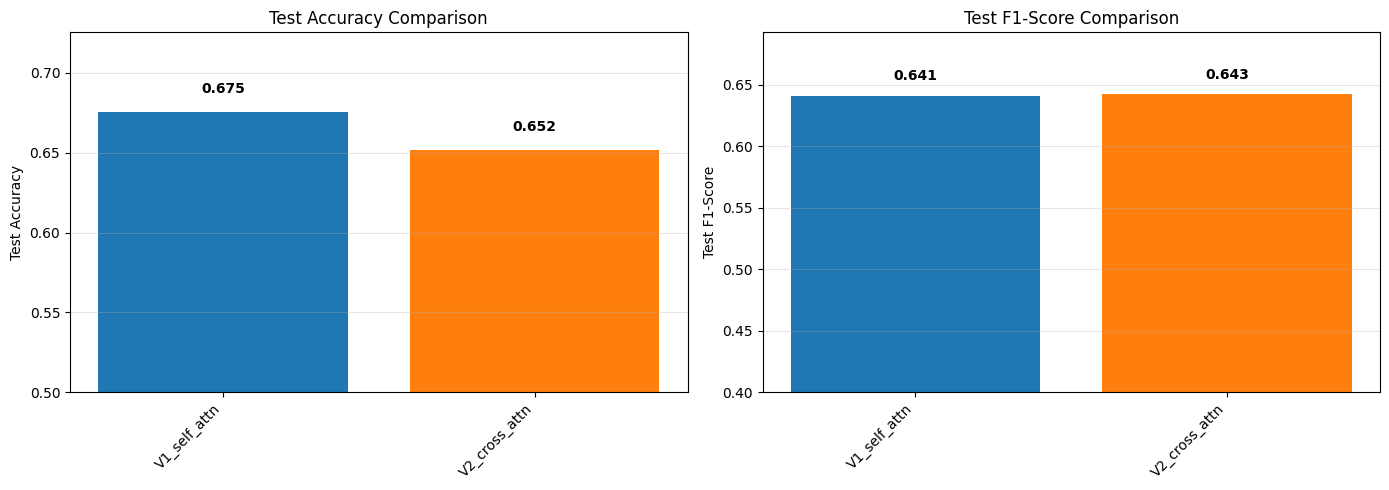

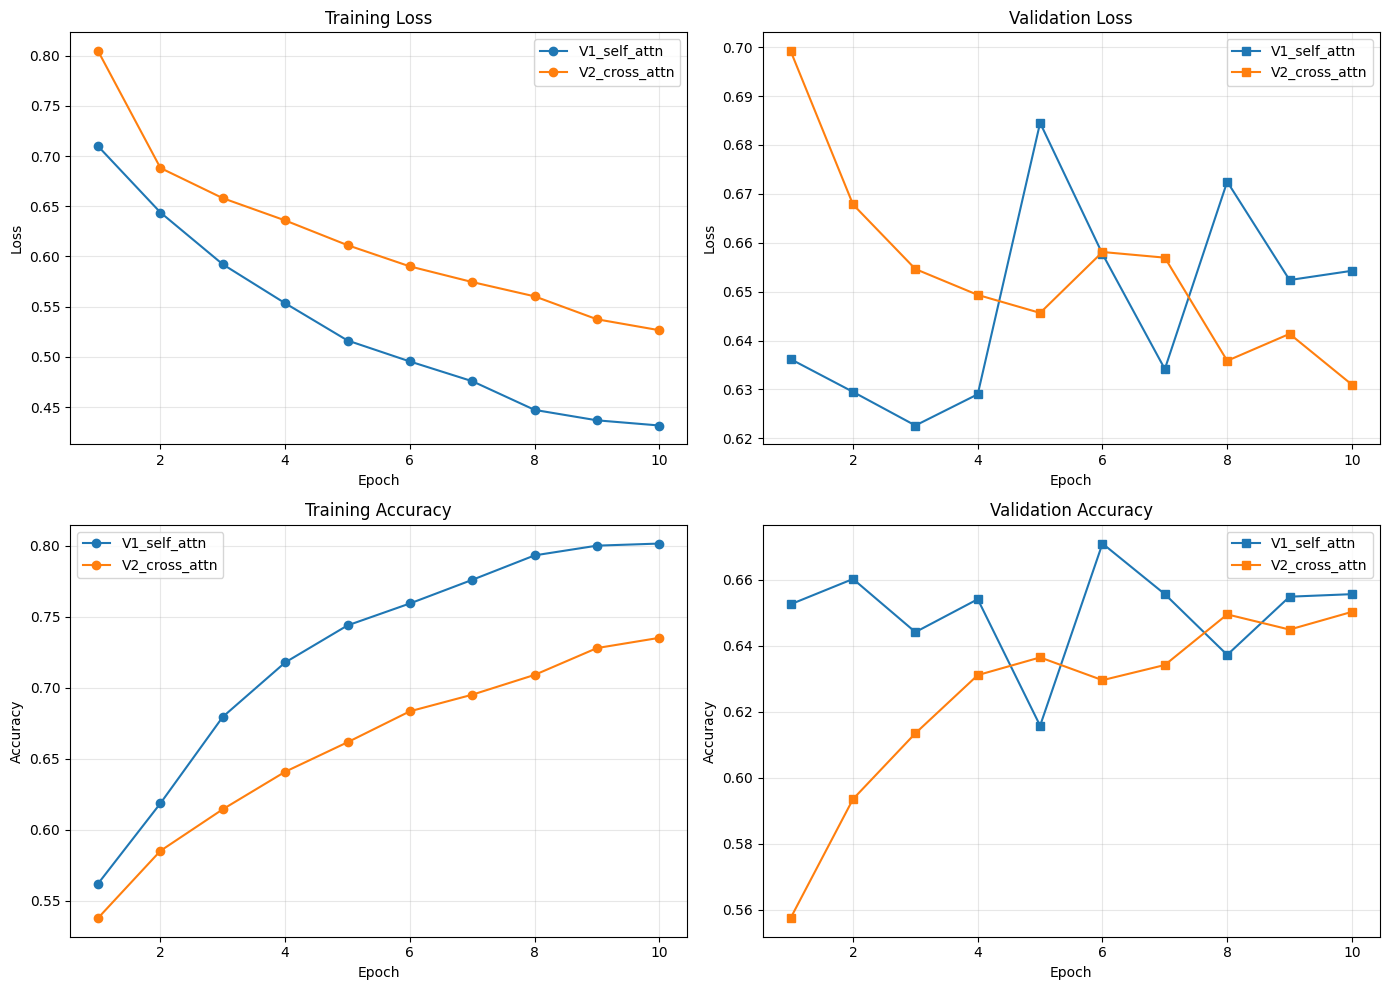


🏆 BEST PERFORMING MODEL:
   Variant: variant_1_self_attn
   Description: Self-Attention with Stable Attention Pooling
   Test Accuracy: 0.6754
   Test F1-Score: 0.6411


In [41]:
%pip install tabulate

import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Summary Table
print("\n" + "="*70)
print("ABLATION STUDY RESULTS SUMMARY")
print("="*70 + "\n")

table_data = [['Variant', 'Description', 'Best Epoch', 'Val Acc', 'Test Acc', 'Test F1']]
for name, results in ablation_results.items():
    table_data.append([
        name.replace('variant_', 'V'),
        results['description'],
        results['best_epoch'],
        f"{results['best_val_acc']:.4f}",
        f"{results['test_acc']:.4f}",
        f"{results['test_f1']:.4f}"
    ])

print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

# 2. Bar Charts - Test Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

variants = list(ablation_results.keys())
test_accs = [ablation_results[v]['test_acc'] for v in variants]
test_f1s = [ablation_results[v]['test_f1'] for v in variants]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Accuracy comparison
ax1.bar(range(len(variants)), test_accs, color=colors[:len(variants)])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy Comparison')
ax1.set_xticks(range(len(variants)))
ax1.set_xticklabels([v.replace('variant_', 'V') for v in variants], rotation=45, ha='right')
ax1.set_ylim(0.5, max(test_accs) + 0.05)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(test_accs):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score comparison
ax2.bar(range(len(variants)), test_f1s, color=colors[:len(variants)])
ax2.set_ylabel('Test F1-Score')
ax2.set_title('Test F1-Score Comparison')
ax2.set_xticks(range(len(variants)))
ax2.set_xticklabels([v.replace('variant_', 'V') for v in variants], rotation=45, ha='right')
ax2.set_ylim(0.4, max(test_f1s) + 0.05)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(test_f1s):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('ablation_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for variant_name, results in ablation_results.items():
    history = results['training_history']
    epochs = range(1, len(history['train_loss']) + 1)
    label = variant_name.replace('variant_', 'V')
    
    # Train loss
    axes[0, 0].plot(epochs, history['train_loss'], marker='o', label=label)
    # Val loss
    axes[0, 1].plot(epochs, history['val_loss'], marker='s', label=label)
    # Train acc
    axes[1, 0].plot(epochs, history['train_acc'], marker='o', label=label)
    # Val acc
    axes[1, 1].plot(epochs, history['val_acc'], marker='s', label=label)

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Best Model Identification
best_variant = max(ablation_results.items(), key=lambda x: x[1]['test_acc'])
print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"   Variant: {best_variant[0]}")
print(f"   Description: {best_variant[1]['description']}")
print(f"   Test Accuracy: {best_variant[1]['test_acc']:.4f}")
print(f"   Test F1-Score: {best_variant[1]['test_f1']:.4f}")